In [68]:
import os
import sys
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.svm import LinearSVC
import matplotlib
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
        sys.path.append(module_path)
        
from src import data_prepare

import seaborn as sns


from sklearn.ensemble import RandomForestClassifier
from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import LogisticRegression
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB

import warnings
warnings.filterwarnings('ignore')

In [71]:
post, thread=data_prepare.load_train_data()
post_test, thread_test=data_prepare.load_test_data()
label_map=data_prepare.load_label_map()

In [72]:
label_map

,type_id,description
type_name,,
bastard,0,These are mafia games where the moderator is a...
beginners-mafia,1,"Simple games with fixed rules, tailored toward..."
byor,2,"""Bring Your Own Role"": custom games where the ..."
classic,3,"In ""classic"" games, all players know what role..."
closed-setup,4,Closed setups mean that players do not know wh...
cybrid,5,"A custom, titled mafia game with multiple ""evi..."
kotm,6,"""King of the Mafia"": multiple mafia mini-games..."
non-mafia-game,7,Games which are sufficiently different from Ma...
other,8,"Non-game threads, such as discussion topics, s..."


In [56]:
num=len(thread)
train_data_to_clean=[]
clean_train_data = []
clean_test_data=[]
test_data_to_clean=[]

In [29]:
post.head(3)

,thread_num,user,text,quotes
0,45016,Mephansteras,"Basically, this is where we talk about what ga...",[]
1,45016,dakarian,The currently running or about to run games (i...,[]
2,45016,webadict,And mine's started.\r\r\r\n\r\r\r\nI'll try to...,[]


In [30]:
thread.head(3)

,thread_num,thread_name,thread_label,thread_replies,thread_label_id
0,45016,Games Threshold Discussion and List [Vote for ...,other,5703,8
1,88720,New Player's Guide to the Subforum - New to Ma...,other,961,8
2,39338,Mafia: A Basic Tutorial,other,79,8


In [57]:
for item in thread.itertuples():
    buf=post[post["thread_num"]==item.thread_num]
    line=str()
    line=line+item.thread_name
    #for row in buf.itertuples():
     #   line=line+str(row.text)
    train_data_to_clean.append(line)
    
    
    
for item in thread_test.itertuples():
    buf=post_test[post_test["thread_num"]==item.thread_num]
    line=str()
    line=line+item.thread_name
    #for row in buf.itertuples():
     #   line=line+str(row.text)
    test_data_to_clean.append(line)

In [69]:
for item in train_data_to_clean:
    clean_train_data.append(data_prepare.clean(item))
    
    
for item in test_data_to_clean:
    clean_test_data.append(data_prepare.clean(item))

In [59]:
X_test=clean_test_data
X_train=clean_train_data
y_train=thread["thread_label_id"]
#X_train, X_val, y_train, y_val = train_test_split(clean_train_data, thread["thread_label_id"], test_size=0.3, random_state=213)

In [60]:
vectorizer = TfidfVectorizer(sublinear_tf=True, norm='l2', encoding='latin-1', ngram_range=(1, 2))

train_data_features = vectorizer.fit_transform(X_train).toarray()

test_data_features = vectorizer.transform(X_test).toarray()

In [61]:
models = [
    RandomForestClassifier(n_estimators=100),
    #ClassifierChain(LogisticRegression()),
    #BinaryRelevance(GaussianNB()),
    LinearSVC(),
    #MultinomialNB(),
    #LogisticRegression()
]

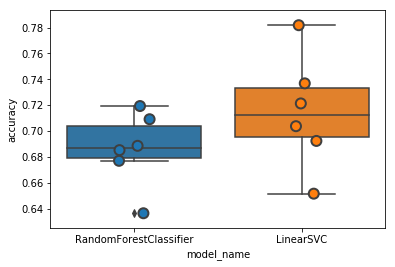

In [70]:
CV=6
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, train_data_features, y_train, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])


sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=10, jitter=True, edgecolor="gray", linewidth=2)

plt.show()

In [63]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.714583
RandomForestClassifier    0.675046
Name: accuracy, dtype: float64

In [ ]:
classifier = ClassifierChain(LogisticRegression())

classifier.fit(train_data_features, y_train.as_matrix())

predictions = classifier.predict(val_data_features)
# accuracy
print("Accuracy = ",accuracy_score(y_val,predictions.A))
print("\n")

In [39]:
forest = RandomForestClassifier(n_estimators = 100)

forest = forest.fit(train_data_features, y_train)

test_predict = forest.predict(val_data_features)

from sklearn.metrics import accuracy_score

acc = accuracy_score(y_val, val_predict)

print("Accuracy on the IMDB dataset: {:.2f}".format(acc*100))

model_name
LinearSVC                 0.693936
LogisticRegression        0.614928
MultinomialNB             0.567072
RandomForestClassifier    0.659795
Name: accuracy, dtype: float64

In [13]:


classifier = BinaryRelevance(GaussianNB())

classifier.fit(train_data_features, y_train.as_matrix())

predictions = classifier.predict(val_data_features)

print("Accuracy = ",accuracy_score(y_val,predictions.A))

In [64]:
model = LinearSVC()
model.fit(train_data_features, y_train)
y_pred = model.predict(test_data_features)

# Evaluation
#print(accuracy_score(y_pred, y_val))

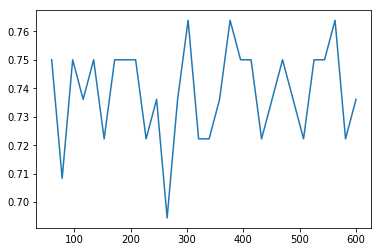

In [35]:
plt.plot(l,k)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

%%time
from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

In [21]:
test_data_features.head()

,posts,absence,accepting,active,activity,actually,age,agent,aka,alien,...,xxiii,xxiv,xxv,ya,yes,yet,yo,zathras,zerzooton,zombie
0,5704,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,962,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,80,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1720,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,308,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
from sklearn.tree import DecisionTreeClassifier

cls = DecisionTreeClassifier(random_state=1000)
cls.fit(train_data_features, y_train)
third = cls.predict(test_data_features)

In [66]:
lab=pd.Series(y_pred)
ans = pd.concat([thread_test["thread_num"],lab], axis=1, keys=['thread_num', 'thread_label_id'])
ans=ans.set_index("thread_num")
ans.head()

,thread_label_id
thread_num,
126856,8
132415,8
134482,8
133728,1
134270,0


In [ ]:
print(second)

In [ ]:
second=second.data
second

In [46]:
lab=pd.Series(third)
ans = pd.concat([thread_test["thread_num"],lab], axis=1, keys=['thread_num', 'thread_label_id'])
ans=ans.set_index("thread_num")
ans.head()

,thread_label_id
thread_num,
126856,12
132415,12
134482,12
133728,11
134270,8


In [67]:
module_path=os.path.join(module_path,"submissions")
ans.to_csv(os.path.join(module_path,"sol15.csv"))